In [107]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations  
from adaptive_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from hexad_answer_bot import *
plt.rcParams["figure.figsize"]=(10,7)
import pandas as pd
hexad_types_full = ["Player", "Achiever", "Philanthropist", "Disruptor", "Socializer", "Free Spirit"]
import logging
gym.logger.setLevel(logging.CRITICAL)

#### Environment Init

In [108]:
corr_g_e=list(corr_gamification_elements.values())
sample_g_e=list(sample_gamification_elements.values())
g_e=sample_g_e[1::2]
colors=['violet','purple','red','sienna',
        'darkorange','burlywood','gold','darkgoldenrod',
        'olivedrab','lawngreen','deepskyblue','steelblue']
ge2c={"Nothing":'black'}
for i in range(len(g_e)):
    ge2c[g_e[i].name]=colors[i]
#hexad=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict
hexad=hexad_load_dict(pl=3,ach=3,ph=3,dis=3,s=3,fs=3).load_dict
fatigue_penalty=0.05
fatigue_replenishment=0.01
nothing_reward=75
rrange=(1.0,1.3,1.7)
increase=(0.2,0.1,0.05)
decrease=(0.1,0.1,0.1)
pref_min=0.2
seed=10101

In [109]:
env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=g_e,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(400,800),
               nothing_reward=nothing_reward,
               fatigue_reduction=fatigue_penalty,
               fatigue_replenish=fatigue_replenishment,
               pref_ranges=rrange,
               pref_increase=increase,
               pref_decrease=decrease,
               pref_min=pref_min,
               seed=seed
               )
obs,_=env.reset()

#### Answer Bot Init

In [110]:
uncertainty=.1
divisor=5.5
starting_threshold=.1
gain_modifier=0.02
amount=1
#ht=copy.deepcopy(hexad)
ht=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict

In [111]:
bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(ht),
        uncertainty=uncertainty,
        divisor=divisor,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )

#### Agent init

In [112]:
#general parameters
learn_rate=0.002
discount_factor=0.7

In [113]:
#Fatigue-aware parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(1e5)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [114]:
fa_agent=FatigueAwareAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=fa_agent.train(env=env,iterations=training_iterations,trunc_error=True)

In [115]:
#Epsilon agent parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(1e5)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [116]:
e_agent=EpsilonAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=e_agent.train(env=env,iterations=training_iterations,trunc_error=True)

In [117]:

basic_agent=BasicAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   )
train_error=basic_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [118]:
#RandomBestOfX parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(1e5)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*4/5000)
x=3

In [119]:

boX_agent=RandomBestOfX(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   X=x
                   )

train_error=boX_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [120]:
agents={"Basic":basic_agent,"Epsilon":e_agent,"BestOfX":boX_agent,"FatigueAware":fa_agent}
init_q_values={}
for name,agent in agents.items():
    init_q_values[name]=copy.deepcopy(agent.q_values)

#### Testing Functions

In [121]:
def test_env_agent(env,agent,answer_bot,test_iterations,retrain_iterations,random_retrain,training_lr):
    rewards=[]
    choices=[]
    best=[]
    agent_error=[]
    actions=defaultdict(lambda:{'x':[],'y':[]})
    hexad_diff=[]
    hd_stats={'mean':[],'std':[]}
    obs,info=env.reset()
    for i in tqdm(range(test_iterations),miniters=int(test_iterations/50)):
        best.append(env.get_best_action())
        act=agent.get_action(obs,avoid_reps=True)
        h_type=env.ge[env.action_to_ge[act]].type
        answer,_=answer_bot.get_answer(h_type)
        choice,reward,new_obs,info,error=agent\
            .step_and_update(env=env,
                            obs=obs,
                            answer=answer,
                            retrain_iterations=retrain_iterations,
                            learning_rate=training_lr,
                            random_retrain=random_retrain,
                            act=act)
        choices.append(choice)
        rewards.append(reward)
        agent_error.append(error)
        actions[choice]['x'].append(i)
        actions[choice]['y'].append(reward)
        diff=0
        d_s=[]
        for typ,val in answer_bot.hexad_profile.items():
            v=abs(val-env.hexad_adjusted[typ])
            diff+=v
            d_s.append(v)
        hd_stats['mean'].append(np.mean(d_s))
        hd_stats['std'].append(np.std(d_s))
        hexad_diff.append(diff)
        obs=new_obs
    return rewards,choices,best,agent_error,actions,(obs,info),hexad_diff,hd_stats

In [122]:
def plot_actions(actions,env,title=None,f=1):
    typ='pl'
    fig=plt.figure(f,figsize=(12,7))
    fig.suptitle(title)
    for i,_ in sorted(actions.items()):
        name=env.action_to_ge[i]
        hex_type=env.ge[name].type
        if hex_type!=None:
            plt.figure(f)
            type_index=hexad_types.index(env.ge[name].type)+1
        else:
            plt.figure(f+1)
        plt.subplot(3,2,type_index)
        plt.ylim(0,1000)
        plt.xlim(0,1000)
        plt.scatter(actions[i]['x'],actions[i]['y'],label=name,s=2)
        ax=plt.gca()
        ax.legend()
    plt.figure(f+2)
    fig.suptitle(title)
    for i in actions:
        plt.scatter(actions[i]['x'],actions[i]['y'],label=env.action_to_ge[i],s=5)
        ax=plt.gca()
        ax.legend()

In [123]:
def get_stats(actions,best,choices):
    type_stats=defaultdict(lambda:0)
    for i in actions:
        try:
            type_stats[sample_gamification_elements[env.action_to_ge[i]].type]+=len(actions[i]['x'])
        except KeyError:
            type_stats['None']+=len(actions[i]['x'])
    s=0
    for i in range(len(best)):
        if best[i][1]==choices[i][1]:
            s+=1
    diff=[best[i][1]-choices[i][1] for i in range(len(choices))]
    diff=np.array(diff)
    diff=diff[diff>0.01]
    actual=pd.Series([env.action_to_ge[item[0]] for item in best],name="Actual Best")
    pred = pd.Series([env.action_to_ge[item[0]] for item in b],name="Predicted Best")
    conf_matrix=pd.crosstab(actual,pred,margins=True)
    return type_stats,s/len(best),diff,conf_matrix

#### Hyperparameter tuning

##### Hexad Preference range

In [124]:
rrange=(1.0,1.3,1.7)
increase=(0.2,0.1,0.05)
decrease=(0.1,0.1,0.1)

ranges = [(1.7,), (0.8,1.2,1.7) ,(0.8,1.0,1.2,1.7) ,(0.61,0.71,1.28,1.38,1.58,1.7)]
increases=[(0.1,),(0.2,0.1,0.05),(0.05,0.066,0.1,0.05) ,(0.1,0.03,0.1,0.03,0.1,0.03),]
decreases=[(0.1,),(0.1,0.1,0.1) ,(0.05,0.1,0.066,0.05) ,(0.1,0.03,0.1,0.03,0.1,0.03),]
test_range=[*zip(ranges,increases,decreases)]
for a in decreases:
    print(f"{a} & ",end='')
print()


(0.1,) & (0.1, 0.1, 0.1) & (0.05, 0.1, 0.066, 0.05) & (0.1, 0.03, 0.1, 0.03, 0.1, 0.03) & 


In [125]:
tests=500
retrains=2000
retrain_learn_rate=0.3
accs={}
a_e={}
d_b={}
hexad_diff={}
j=0
for name,agent in agents.items():
    print(name)
    random_retrain=(name=="Basic" or name=='BestOfX')
    accs[name]={'avg':[],'std':[]}
    a_e[name]={'avg':[],'std':[]}
    d_b[name]={'avg':[],'std':[]}
    hexad_diff[name]={'avg':[],'std':[]}
    for rrange,increase,decrease in tqdm(test_range):
        print(f"Current test: {rrange}")
        print("Iteration: ",end='')
        accuracy=[]
        diff_from_best=[]
        agent_error=[]
        abs_hex_diff=[]
        for j in range(10):
            env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=g_e,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(400,800),
               nothing_reward=nothing_reward,
               fatigue_reduction=fatigue_penalty,
               fatigue_replenish=fatigue_replenishment,
               pref_ranges=rrange,
               pref_increase=increase,
               pref_decrease=decrease,
               pref_min=pref_min,
               seed=seed
               )
            obs,_=env.reset()
            agent.reset()
            agent.train(env=env,iterations=training_iterations,trunc_error=True)
            obs,_=env.reset()
            print(f"{j+1}, ",end='')
            r,c,b,e,a,_,hd,hd_stats=test_env_agent(env,agent,
                        answer_bot=bot,
                        test_iterations=tests,
                        retrain_iterations=retrains,
                        random_retrain=random_retrain,
                        training_lr=retrain_learn_rate)
            t,acc,diff,conf_matrix = get_stats(a,b,[*zip(c,r)])
            accuracy.append(acc)
            diff_from_best.extend((diff))
            agent_error.extend((e))
            abs_hex_diff.extend(hd)
            bot = ScoreChangeBot(
                hexad_types=copy.deepcopy(ht),
                uncertainty= uncertainty,
                divisor=divisor,
                starting_change_threshold=starting_threshold,
                change_gain_modifier=gain_modifier,
                change_amount=amount,
                seed=seed,
            )
        print()  
        hexad_diff[name]['avg'].append(np.average(abs_hex_diff))
        hexad_diff[name]['std'].append(np.std(abs_hex_diff))
        accs[name]['avg'].append(np.average(accuracy))
        accs[name]['std'].append(np.std(accuracy))
        a_e[name]['avg'].append(np.average(agent_error))
        a_e[name]['std'].append(np.std(agent_error))
        d_b[name]['avg'].append(np.average(diff_from_best))
        d_b[name]['std'].append(np.std(diff_from_best))

Basic


  0%|          | 0/4 [00:00<?, ?it/s]

Current test: (1.7,)
Iteration: 1, 

100%|██████████| 500/500 [00:17<00:00, 28.05it/s]


2, 

100%|██████████| 500/500 [00:17<00:00, 28.66it/s]


3, 

100%|██████████| 500/500 [00:17<00:00, 28.26it/s]


4, 

100%|██████████| 500/500 [00:17<00:00, 28.53it/s]


5, 

100%|██████████| 500/500 [00:18<00:00, 27.21it/s]


6, 

100%|██████████| 500/500 [00:17<00:00, 28.75it/s]


7, 

100%|██████████| 500/500 [00:17<00:00, 27.89it/s]


8, 

100%|██████████| 500/500 [00:18<00:00, 27.27it/s]


9, 

100%|██████████| 500/500 [00:18<00:00, 27.26it/s]


10, 

 25%|██▌       | 1/4 [03:18<09:55, 198.48s/it]


Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:17<00:00, 27.88it/s]


2, 

100%|██████████| 500/500 [00:17<00:00, 28.15it/s]


3, 

100%|██████████| 500/500 [00:17<00:00, 28.68it/s]


4, 

100%|██████████| 500/500 [00:17<00:00, 28.01it/s]


5, 

100%|██████████| 500/500 [00:17<00:00, 28.27it/s]


6, 

100%|██████████| 500/500 [00:17<00:00, 27.91it/s]


7, 

100%|██████████| 500/500 [00:17<00:00, 28.77it/s]


8, 

100%|██████████| 500/500 [00:17<00:00, 28.92it/s]


9, 

100%|██████████| 500/500 [00:17<00:00, 27.92it/s]


10, 

 50%|█████     | 2/4 [06:34<06:33, 196.86s/it]


Current test: (0.8, 1.0, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:17<00:00, 28.19it/s]


2, 

100%|██████████| 500/500 [00:17<00:00, 28.09it/s]


3, 

100%|██████████| 500/500 [00:18<00:00, 27.69it/s]


4, 

100%|██████████| 500/500 [00:17<00:00, 27.94it/s]


5, 

100%|██████████| 500/500 [00:18<00:00, 27.07it/s]


6, 

100%|██████████| 500/500 [00:18<00:00, 27.77it/s]


7, 

100%|██████████| 500/500 [00:17<00:00, 28.05it/s]


8, 

100%|██████████| 500/500 [00:18<00:00, 27.16it/s]


9, 

100%|██████████| 500/500 [00:17<00:00, 27.99it/s]


10, 

 75%|███████▌  | 3/4 [09:52<03:17, 197.69s/it]


Current test: (0.61, 0.71, 1.28, 1.38, 1.58, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:17<00:00, 28.54it/s]


2, 

100%|██████████| 500/500 [00:17<00:00, 28.33it/s]


3, 

100%|██████████| 500/500 [00:17<00:00, 28.18it/s]


4, 

100%|██████████| 500/500 [00:18<00:00, 27.52it/s]


5, 

100%|██████████| 500/500 [00:17<00:00, 27.89it/s]


6, 

100%|██████████| 500/500 [00:18<00:00, 27.52it/s]


7, 

100%|██████████| 500/500 [00:17<00:00, 28.81it/s]


8, 

100%|██████████| 500/500 [00:17<00:00, 28.75it/s]


9, 

100%|██████████| 500/500 [00:17<00:00, 29.18it/s]


10, 

100%|██████████| 4/4 [13:08<00:00, 197.02s/it]



Epsilon


  0%|          | 0/4 [00:00<?, ?it/s]

Current test: (1.7,)
Iteration: 1, 

100%|██████████| 500/500 [00:21<00:00, 23.03it/s]


2, 

100%|██████████| 500/500 [00:21<00:00, 23.34it/s]


3, 

100%|██████████| 500/500 [00:20<00:00, 23.84it/s]


4, 

100%|██████████| 500/500 [00:20<00:00, 24.27it/s]


5, 

100%|██████████| 500/500 [00:20<00:00, 24.09it/s]


6, 

100%|██████████| 500/500 [00:20<00:00, 24.03it/s]


7, 

100%|██████████| 500/500 [00:20<00:00, 24.01it/s]


8, 

100%|██████████| 500/500 [00:21<00:00, 23.80it/s]


9, 

100%|██████████| 500/500 [00:20<00:00, 23.85it/s]


10, 

 25%|██▌       | 1/4 [03:47<11:22, 227.49s/it]


Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:21<00:00, 23.31it/s]


2, 

100%|██████████| 500/500 [00:21<00:00, 23.48it/s]


3, 

100%|██████████| 500/500 [00:21<00:00, 23.70it/s]


4, 

100%|██████████| 500/500 [00:21<00:00, 23.24it/s]


5, 

100%|██████████| 500/500 [00:21<00:00, 23.09it/s]


6, 

100%|██████████| 500/500 [00:21<00:00, 22.99it/s]


7, 

100%|██████████| 500/500 [00:21<00:00, 23.47it/s]


8, 

100%|██████████| 500/500 [00:21<00:00, 23.12it/s]


9, 

100%|██████████| 500/500 [00:21<00:00, 23.23it/s]


10, 

 50%|█████     | 2/4 [07:40<07:41, 230.83s/it]


Current test: (0.8, 1.0, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:21<00:00, 23.41it/s]


2, 

100%|██████████| 500/500 [00:21<00:00, 22.80it/s]


3, 

100%|██████████| 500/500 [00:21<00:00, 23.50it/s]


4, 

100%|██████████| 500/500 [00:21<00:00, 22.93it/s]


5, 

100%|██████████| 500/500 [00:21<00:00, 22.90it/s]


6, 

100%|██████████| 500/500 [00:21<00:00, 23.34it/s]


7, 

100%|██████████| 500/500 [00:22<00:00, 22.64it/s]


8, 

100%|██████████| 500/500 [00:21<00:00, 23.57it/s]


9, 

100%|██████████| 500/500 [00:21<00:00, 23.25it/s]


10, 

 75%|███████▌  | 3/4 [11:35<03:52, 232.55s/it]


Current test: (0.61, 0.71, 1.28, 1.38, 1.58, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:22<00:00, 22.70it/s]


2, 

100%|██████████| 500/500 [00:21<00:00, 23.79it/s]


3, 

100%|██████████| 500/500 [00:20<00:00, 23.98it/s]


4, 

100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


5, 

100%|██████████| 500/500 [00:20<00:00, 24.16it/s]


6, 

100%|██████████| 500/500 [00:21<00:00, 23.54it/s]


7, 

100%|██████████| 500/500 [00:20<00:00, 24.49it/s]


8, 

100%|██████████| 500/500 [00:21<00:00, 23.14it/s]


9, 

100%|██████████| 500/500 [00:22<00:00, 22.06it/s]


10, 

100%|██████████| 4/4 [15:26<00:00, 231.70s/it]



BestOfX


  0%|          | 0/4 [00:00<?, ?it/s]

Current test: (1.7,)
Iteration: 1, 

100%|██████████| 500/500 [00:23<00:00, 21.72it/s]


2, 

100%|██████████| 500/500 [00:22<00:00, 22.49it/s]


3, 

100%|██████████| 500/500 [00:23<00:00, 21.55it/s]


4, 

100%|██████████| 500/500 [00:21<00:00, 22.99it/s]


5, 

100%|██████████| 500/500 [00:25<00:00, 19.90it/s]


6, 

100%|██████████| 500/500 [00:21<00:00, 23.41it/s]


7, 

100%|██████████| 500/500 [00:22<00:00, 22.28it/s]


8, 

100%|██████████| 500/500 [00:22<00:00, 21.82it/s]


9, 

100%|██████████| 500/500 [00:22<00:00, 21.91it/s]


10, 

 25%|██▌       | 1/4 [04:08<12:25, 248.37s/it]


Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:21<00:00, 23.26it/s]


2, 

100%|██████████| 500/500 [00:21<00:00, 23.02it/s]


3, 

100%|██████████| 500/500 [00:21<00:00, 23.10it/s]


4, 

100%|██████████| 500/500 [00:21<00:00, 22.84it/s]


5, 

100%|██████████| 500/500 [00:24<00:00, 20.43it/s]


6, 

100%|██████████| 500/500 [00:23<00:00, 21.66it/s]


7, 

100%|██████████| 500/500 [00:22<00:00, 22.27it/s]


8, 

100%|██████████| 500/500 [00:21<00:00, 22.95it/s]


9, 

100%|██████████| 500/500 [00:21<00:00, 22.94it/s]


10, 

 50%|█████     | 2/4 [08:14<08:13, 246.88s/it]


Current test: (0.8, 1.0, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:22<00:00, 22.56it/s]


2, 

100%|██████████| 500/500 [00:21<00:00, 22.91it/s]


3, 

100%|██████████| 500/500 [00:20<00:00, 24.18it/s]


4, 

100%|██████████| 500/500 [00:20<00:00, 24.08it/s]


5, 

100%|██████████| 500/500 [00:23<00:00, 21.56it/s]


6, 

100%|██████████| 500/500 [00:22<00:00, 22.13it/s]


7, 

100%|██████████| 500/500 [00:22<00:00, 22.43it/s]


8, 

100%|██████████| 500/500 [00:22<00:00, 21.74it/s]


9, 

100%|██████████| 500/500 [00:22<00:00, 21.79it/s]


10, 

 75%|███████▌  | 3/4 [12:18<04:05, 245.82s/it]


Current test: (0.61, 0.71, 1.28, 1.38, 1.58, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:22<00:00, 21.84it/s]


2, 

100%|██████████| 500/500 [00:22<00:00, 22.52it/s]


3, 

100%|██████████| 500/500 [00:22<00:00, 22.39it/s]


4, 

100%|██████████| 500/500 [00:21<00:00, 23.21it/s]


5, 

100%|██████████| 500/500 [00:22<00:00, 22.16it/s]


6, 

100%|██████████| 500/500 [00:22<00:00, 21.97it/s]


7, 

100%|██████████| 500/500 [00:22<00:00, 21.79it/s]


8, 

100%|██████████| 500/500 [00:23<00:00, 21.53it/s]


9, 

100%|██████████| 500/500 [00:23<00:00, 21.43it/s]


10, 

100%|██████████| 4/4 [16:27<00:00, 247.00s/it]



FatigueAware


  0%|          | 0/4 [00:00<?, ?it/s]

Current test: (1.7,)
Iteration: 1, 

100%|██████████| 500/500 [00:28<00:00, 17.39it/s]


2, 

100%|██████████| 500/500 [00:29<00:00, 17.12it/s]


3, 

100%|██████████| 500/500 [00:29<00:00, 16.90it/s]


4, 

100%|██████████| 500/500 [00:29<00:00, 16.81it/s]


5, 

100%|██████████| 500/500 [00:29<00:00, 17.14it/s]


6, 

100%|██████████| 500/500 [00:28<00:00, 17.84it/s]


7, 

100%|██████████| 500/500 [00:30<00:00, 16.20it/s]


8, 

100%|██████████| 500/500 [00:28<00:00, 17.51it/s]


9, 

100%|██████████| 500/500 [00:27<00:00, 17.96it/s]


10, 

 25%|██▌       | 1/4 [05:15<15:45, 315.09s/it]


Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:27<00:00, 17.90it/s]


2, 

100%|██████████| 500/500 [00:27<00:00, 18.06it/s]


3, 

100%|██████████| 500/500 [00:28<00:00, 17.73it/s]


4, 

100%|██████████| 500/500 [00:27<00:00, 18.42it/s]


5, 

100%|██████████| 500/500 [00:28<00:00, 17.77it/s]


6, 

100%|██████████| 500/500 [00:27<00:00, 17.98it/s]


7, 

100%|██████████| 500/500 [00:28<00:00, 17.80it/s]


8, 

100%|██████████| 500/500 [00:30<00:00, 16.32it/s]


9, 

100%|██████████| 500/500 [00:30<00:00, 16.43it/s]


10, 

 50%|█████     | 2/4 [10:24<10:23, 311.87s/it]


Current test: (0.8, 1.0, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:29<00:00, 17.02it/s]


2, 

100%|██████████| 500/500 [00:31<00:00, 15.74it/s]


3, 

100%|██████████| 500/500 [00:29<00:00, 16.95it/s]


4, 

100%|██████████| 500/500 [00:29<00:00, 17.16it/s]


5, 

100%|██████████| 500/500 [00:29<00:00, 16.77it/s]


6, 

100%|██████████| 500/500 [00:30<00:00, 16.31it/s]


7, 

100%|██████████| 500/500 [00:32<00:00, 15.37it/s]


8, 

100%|██████████| 500/500 [00:42<00:00, 11.66it/s]


9, 

100%|██████████| 500/500 [00:43<00:00, 11.62it/s]


10, 

 75%|███████▌  | 3/4 [16:29<05:36, 336.24s/it]


Current test: (0.61, 0.71, 1.28, 1.38, 1.58, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:37<00:00, 13.46it/s]


2, 

100%|██████████| 500/500 [00:39<00:00, 12.80it/s]


3, 

100%|██████████| 500/500 [00:38<00:00, 12.85it/s]


4, 

100%|██████████| 500/500 [00:37<00:00, 13.37it/s]


5, 

100%|██████████| 500/500 [00:37<00:00, 13.18it/s]


6, 

100%|██████████| 500/500 [00:37<00:00, 13.27it/s]


7, 

100%|██████████| 500/500 [00:38<00:00, 12.94it/s]


8, 

100%|██████████| 500/500 [00:38<00:00, 13.09it/s]


9, 

100%|██████████| 500/500 [00:37<00:00, 13.43it/s]


10, 

100%|██████████| 4/4 [23:17<00:00, 349.30s/it]

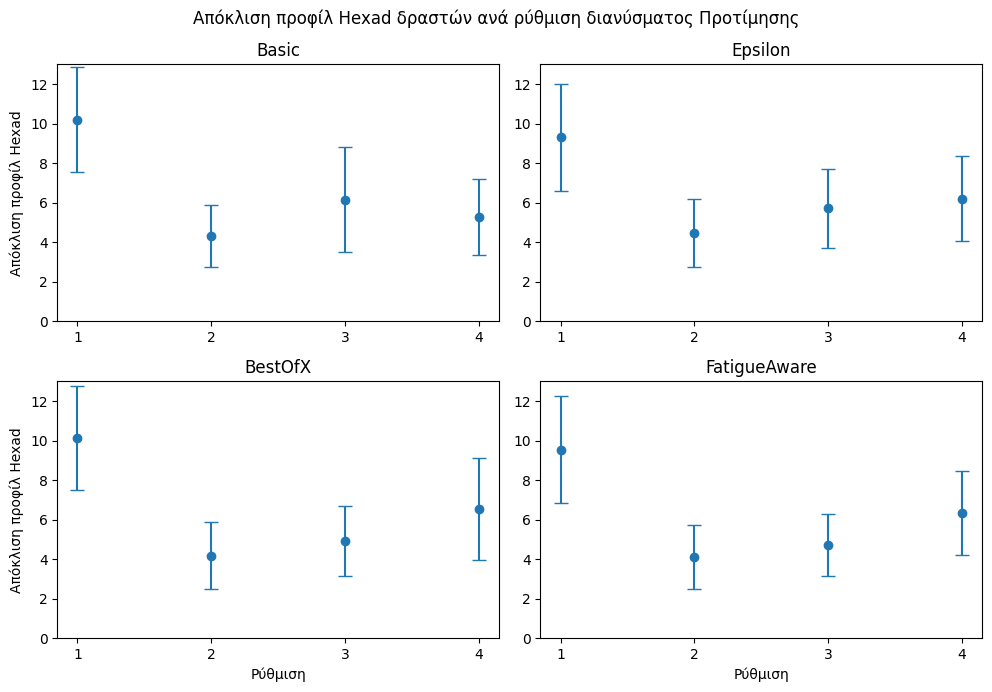

In [130]:
i=1
for name,agent in agents.items():
    ax=plt.subplot(2,2,i)
    av=np.array(hexad_diff[name]['avg'])
    st=np.array(hexad_diff[name]['std'])
    plt.errorbar(range(1,len(ranges)+1),av,st,marker='o',capsize=5,linestyle='',label='Μέση τιμή')
    ax.set_xticks(range(1,len(ranges)+1),['1','2','3','4'])
    plt.title(name)
    plt.ylim(0,13)
    if i in [1, 3]:
        plt.ylabel("Απόκλιση προφίλ Hexad")
    if i in [3, 4]:
        plt.xlabel("Ρύθμιση")
    i+=1
plt.suptitle("Απόκλιση προφίλ Hexad δραστών ανά ρύθμιση διανύσματος Προτίμησης")
plt.tight_layout(pad=1)

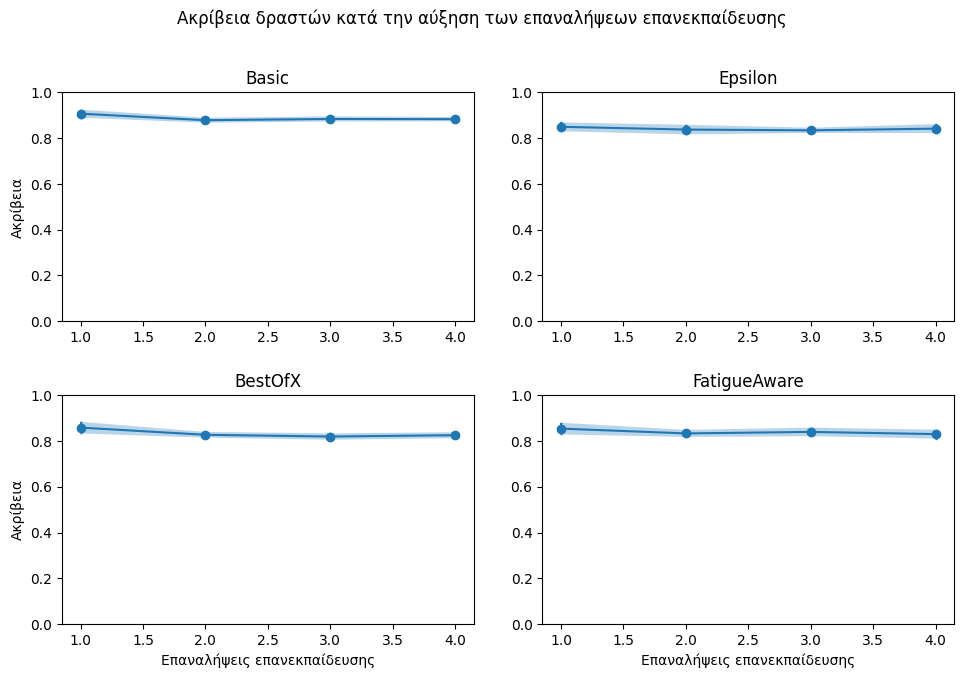

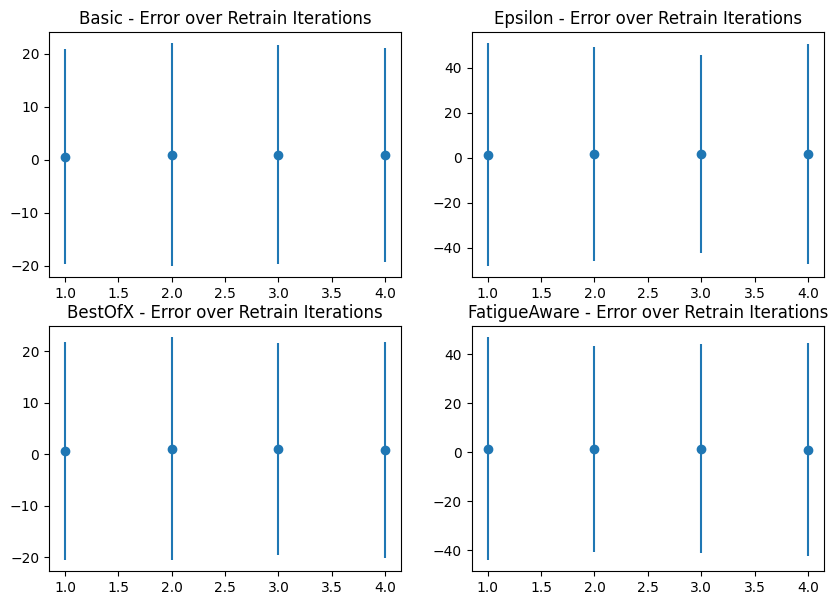

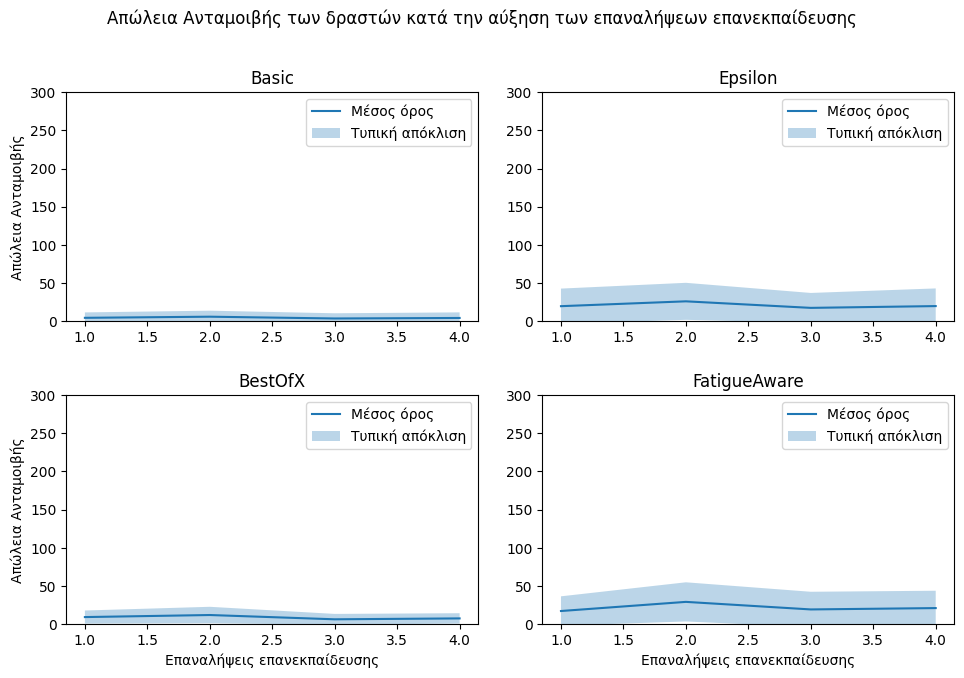

In [128]:
i = 1
for name, agent in agents.items():
    plt.figure(1)
    plt.subplot(2, 2, i)
    plt.errorbar(
        range(1,len(test_range)+1), accs[name]["avg"], accs[name]["std"], marker="o", capsize=1
    )
    plt.fill_between(
        range(1,len(test_range)+1),
        np.array(accs[name]["avg"]) - np.array(accs[name]["std"]),
        np.array(accs[name]["avg"]) + np.array(accs[name]["std"]),
        alpha=0.3,
    )
    plt.tight_layout(pad=2)
    plt.ylim(0, 1)
    if i in [1, 3]:
        plt.ylabel("Ακρίβεια")
    if i in [3, 4]:
        plt.xlabel("Επαναλήψεις επανεκπαίδευσης")
    plt.title("{}".format(name))
    plt.suptitle("Ακρίβεια δραστών κατά την αύξηση των επαναλήψεων επανεκπαίδευσης")
    plt.figure(2)
    plt.subplot(2, 2, i)
    plt.errorbar(
        range(1,len(test_range)+1), a_e[name]["avg"], a_e[name]["std"], marker="o", linestyle=""
    )
    plt.title("{} - Error over Retrain Iterations".format(name))
    plt.figure(3)
    plt.subplot(2, 2, i)
    y = np.array(d_b[name]["avg"])
    y_error = np.array(d_b[name]["std"])
    plt.plot(range(1,len(test_range)+1), y, label="Μέσος όρος")
    plt.fill_between(
        range(1,len(test_range)+1), y - y_error / 2, y + y_error / 2, alpha=0.3, label="Τυπική απόκλιση"
    )
    plt.legend()
    plt.title("{}".format(name))
    plt.tight_layout(pad=2)
    plt.ylim(0, 300)
    if i in [1, 3]:
        plt.ylabel("Απώλεια Ανταμοιβής")
    if i in [3, 4]:
        plt.xlabel("Επαναλήψεις επανεκπαίδευσης")
    plt.suptitle(
        "Απώλεια Ανταμοιβής των δραστών κατά την αύξηση των επαναλήψεων επανεκπαίδευσης"
    )
    i += 1